In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c

C:\Users\Davide\AppData\Local\Temp\ipykernel_10076\3994849476.py:18: RuntimeWarning: divide by zero encountered in divide
  xi = 1j/(R*(G[n]-G))*(1-np.exp(-1j*(G[n]-G)*a))*(1/eps2 - 1/eps1)
C:\Users\Davide\AppData\Local\Temp\ipykernel_10076\3994849476.py:18: RuntimeWarning: invalid value encountered in divide
  xi = 1j/(R*(G[n]-G))*(1-np.exp(-1j*(G[n]-G)*a))*(1/eps2 - 1/eps1)
C:\Users\Davide\AppData\Local\Temp\ipykernel_10076\3994849476.py:18: RuntimeWarning: invalid value encountered in multiply
  xi = 1j/(R*(G[n]-G))*(1-np.exp(-1j*(G[n]-G)*a))*(1/eps2 - 1/eps1)


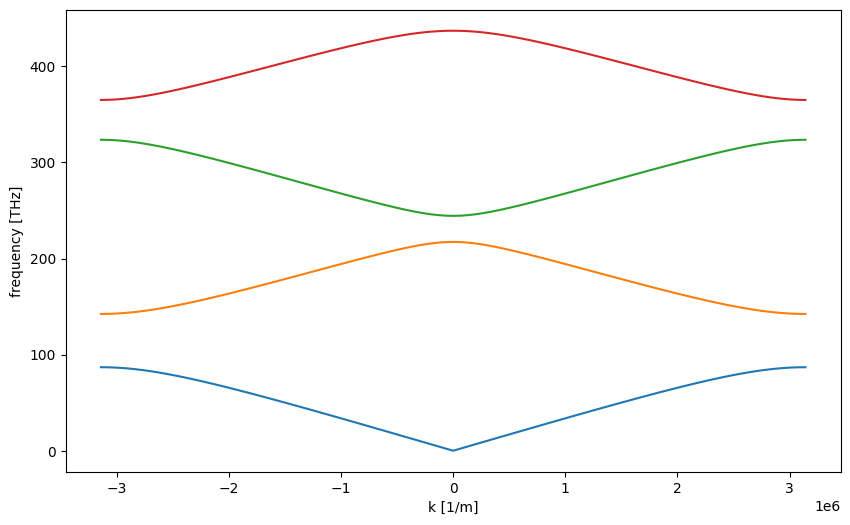

In [137]:
eps1 = 1
eps2 = 5
R = 1e-6
a = R*3/4

Nk = 101
ks = np.linspace(-np.pi/R, np.pi/R, Nk)
N = 30

G = 2*np.pi/R*np.arange(-N, N+1)

xi = np.zeros(2*N+1, dtype = 'complex')

theta = np.zeros((2*N+1, 2*N+1), dtype = 'complex')
omegas = np.zeros((Nk, 2*N+1), dtype="complex")
for i, k in enumerate(ks): 
    for n in np.arange(0, 2*N+1):  
        xi = 1j/(R*(G[n]-G))*(1-np.exp(-1j*(G[n]-G)*a))*(1/eps2 - 1/eps1)  
        xi[np.where(G[n] == G)] = a/R*(1/eps1 - 1/eps2) + 1/eps2   
        theta[n] = xi*(G[n]+k)*(G+k)
    eigenvalues, eigenvectors = np.linalg.eig(theta)
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    omega = np.sqrt(np.real(sorted_eigenvalues)) * c
    omegas[i] = omega

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(ks, omegas[:, :4]*1e-12/(2*np.pi))
ax.set_ylabel("frequency [THz]")
ax.set_xlabel("k [1/m]")
plt.show()

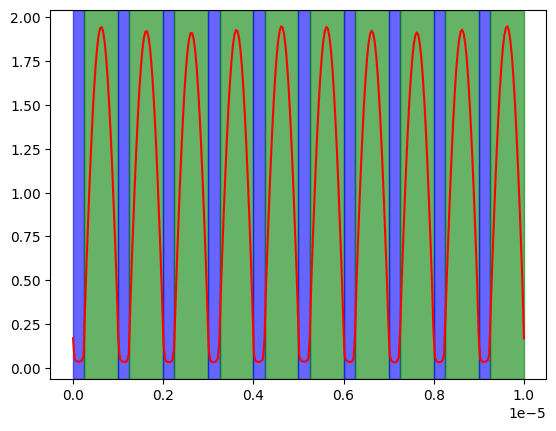

In [138]:
zs = np.linspace(0, 10e-6, 300)
Hs = []
for z in zs:
    u = np.sum(eigenvectors[:,0]*np.exp(1j*G*z))
    H = np.exp(1j*k*z)*u
    Hs = np.append(H, Hs)

plt.plot(zs, np.abs(Hs)**2, color = 'red')
for i in range(10):
    plt.axvspan(R*i, R*i + R-a, alpha=0.6, color='blue')
    plt.axvspan(R*i + R-a, R*i + R, alpha=0.6, color='green')
plt.show()